# Лабораторная работа №3
## ПРОГНОЗИРОВАНИЕ ВРЕМЕННЫХ РЯДОВ НА ОСНОВЕ LSTM-СЕТЕЙ
Комлева Юлия Владимировна

Вариант: 9

Группа: РИМ-281226

9. Декомпозиция ВР вида 3 кратные сезонные компоненты + шум.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import datetime

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,CuDNNLSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import plot_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

%matplotlib inline

Using TensorFlow backend.


In [2]:
MODELS_DIR='models'

In [3]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


In [4]:
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
file = h5py.File('Fort.mat', 'r')
data = file.get('Fort')
Fort = np.array(data)

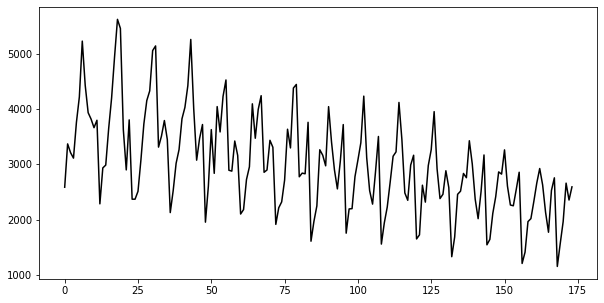

In [6]:
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.show()

In [7]:
def split_signal(inpt, length, batch_size, sclr, show=False):
    f = sclr.fit_transform(inpt)
    f_tr = f[:batch_size]
    f_test = f[batch_size-length:]
    if show:
        plt.figure(figsize = (10, 5))
        plt.plot(f, 'k')
        plt.plot(np.r_[:batch_size],f_tr, 'b')
        plt.plot(np.r_[batch_size-length:len(inpt)],f_test, 'r')
        plt.show()

        print(f_tr.shape[0], f_test.shape[0])
    return f_tr, f_test

In [8]:
def get_ts(source, length, batch_size):
    data_gen = TimeseriesGenerator(source, source,
                                 length=length, sampling_rate=1,
                                 batch_size=batch_size)
    x, yy = data_gen[0]
    xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
#     print(xx.shape)
#     print(yy.shape)
    return torch.Tensor(xx), yy

In [9]:
class TSDataSet(torch.utils.data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
         
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, i):
        
        return torch.from_numpy(self.inputs[i]).unsqueeze(-1).float(), torch.Tensor([self.targets[i]]).squeeze().float()

In [10]:
def get_dataset(inpt, length):
    F_t=F_tr.ravel().astype(np.float)
    F_data=np.array([[F_t[i:i+length+1][:-1],F_t[i:i+length+1][-1]] for i in range(len(F_tr)-length)])
    return TSDataSet(F_data[:,0],F_data[:,1])

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))

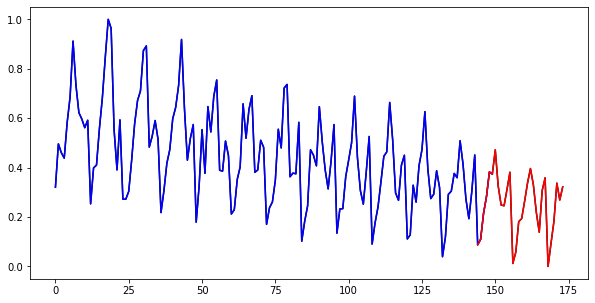

150 30


In [12]:
F_tr, F_test = split_signal(Fort, 6, 150, scaler, True)

Модели сети 6 порядка авторегрессии на (150-6) = 144 смежных точках ряда.

In [13]:
train_xx, train_yy = get_ts(F_tr, 6, 150)

In [14]:
print(train_xx.shape) 
print(train_xx[0], train_yy[0])
print(train_xx[1], train_yy[1])

torch.Size([144, 1, 6])
tensor([[0.3206, 0.4960, 0.4606, 0.4384, 0.5829, 0.6859]]) [0.91196237]
tensor([[0.4960, 0.4606, 0.4384, 0.5829, 0.6859, 0.9120]]) [0.73297491]


In [15]:
test_xx, test_yy = get_ts(F_test, 6, 150)

In [16]:
print(test_xx.shape) 
print(test_xx[0], test_yy[0])
print(test_xx[1], test_yy[1])

torch.Size([24, 1, 6])
tensor([[0.0876, 0.1095, 0.2146, 0.2825, 0.3826, 0.3737]]) [0.47177419]
tensor([[0.1095, 0.2146, 0.2825, 0.3826, 0.3737, 0.4718]]) [0.32526882]


In [17]:
train_set=get_dataset(F_tr,6)

In [18]:
batch_size=1
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [19]:
class Net(nn.Module):
    def __init__(self, batch_size, input_dim, hidden_dim, drpout=None):
        super(Net, self).__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.drpout = drpout
        
        if not self.drpout:
            self.lstm1 = nn.LSTM(self.input_dim, self.hidden_dim) 
            self.fc1 = nn.Linear(self.hidden_dim, 1)
        else:
            self.lstm1 = nn.LSTM(self.input_dim, self.hidden_dim)
            self.lstm2 = nn.LSTM(self.hidden_dim, self.hidden_dim)
            self.lstm3 = nn.LSTM(self.hidden_dim, self.hidden_dim)
            self.fc1 = nn.Linear(self.hidden_dim, 1)
            
            self.dropout = nn.Dropout(0.5) 

    def init_hidden(self):
        return (torch.zeros(2, self.batch_size, self.hidden_dim),
                torch.zeros(2, self.batch_size, self.hidden_dim))

    def forward(self, x): 
        if not self.drpout:
            x, self.hidden = self.lstm1(x.view(len(x), self.batch_size, -1))
            x = self.fc1(x[-1].view(self.batch_size, -1))
        else:
            x, self.hidden = self.lstm1(x.view(len(x), self.batch_size, -1))
            x = self.dropout(x)
            x, self.hidden = self.lstm2(x.view(len(x), self.batch_size, -1))
            x = self.dropout(x)
            x, self.hidden = self.lstm3(x.view(len(x), self.batch_size, -1))
            x = self.fc1(x[-1].view(self.batch_size, -1))
        
        return x.view(-1)

In [20]:
net = Net(batch_size, 6, 20, 0.2).to(device)
net

Net(
  (lstm1): LSTM(6, 20)
  (lstm2): LSTM(20, 20)
  (lstm3): LSTM(20, 20)
  (fc1): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [21]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(net.parameters())

In [22]:
#for epoch in range(100):   
#    net.hidden = net.init_hidden()
#    for i, data in enumerate(train_loader):
#
#        inputs, labels = data[0].to(device), data[1].to(device)
#
#
#        optimizer.zero_grad()
#
#
#        outputs = net(inputs)
#        loss = criterion(outputs, labels)
#        loss.backward()
#        optimizer.step()
#
#    if (epoch + 1) % 10 == 0:
#        print('epoch %d, training loss: %.3f' %
#          (epoch+1, loss.item()))
#
#print('finish')

In [23]:
#pred_train=[]
#for i in range(len(train_xx)):
#    out=net(train_xx[i].unsqueeze(-1).to(device))
#    pred_train.append(out.detach().cpu().item())
#pred_train=np.array(pred_train)
#trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
#plt.figure(figsize = (10, 5))
#plt.plot(Fort, 'k')
#plt.plot(np.r_[6:150],trainPredict, 'b')
#plt.show()

In [24]:
#pred_test=[]
#for i in range(len(test_xx)):
#    out=net(test_xx[i].unsqueeze(-1).to(device))
#    pred_test.append(out.detach().cpu().item())
#pred_test=np.array(pred_test)
#testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
#plt.figure(figsize = (10, 5))
#plt.plot(Fort, 'k')
#plt.plot(np.r_[150:174],testPredict, 'b')
#plt.show()

In [25]:
#pred_forecast=[]
#inp=test_xx[-1].unsqueeze(-1).to(device)
#for i in range(24):
#    out=net(inp)
#    out=out.detach().cpu().item()
#    pred_forecast.append(out)
#    inp[0,0,0]=out
#    inp=inp.roll(-1)
#pred_forecast=np.array(pred_forecast)
#forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
#plt.figure(figsize = (10, 5))
#plt.plot(Fort, 'k')
#plt.plot(np.r_[len(Fort)-1:len(Fort)+24-1],forecastPredict, 'b')
#plt.show()

In [26]:
def train(inpt, epchs, f_msk, **kwargs):
    start=datetime.datetime.now()
    
    delay=kwargs['delay']
    neuron=kwargs['neuron']
    btch_sz=kwargs['btch_sz']
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    F_tr, F_test = split_signal(inpt, delay, btch_sz, scaler)
    train_xx, train_yy = get_ts(F_tr, delay, btch_sz)
    test_xx, test_yy = get_ts(F_test, delay, btch_sz)
    train_set=get_dataset(F_tr,delay)
    batch_size=1
    train_loader = torch.utils.data.DataLoader(train_set, 
                                               batch_size=batch_size, 
                                               shuffle=True)

    net = Net(batch_size, delay, neuron, kwargs.get('drpout')).to(device)



    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(net.parameters())

    train_mse=[]
    test_mse=[]
    
    for epoch in range(epochs):
        net.train()
        net.hidden = net.init_hidden()
        for i, data in enumerate(train_loader):

            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

#         if (epoch + 1) % 10 == 0:
#             print('epoch %d, training loss: %.3f' %
#               (epoch+1, loss.item()))

        net.eval()

        pred_train=[]
        for i in range(len(train_xx)):
            out=net(train_xx[i].unsqueeze(-1).to(device))
            pred_train.append(out.detach().cpu().item())
        pred_train=np.array(pred_train)

        pred_test=[]
        for i in range(len(test_xx)):
            out=net(test_xx[i].unsqueeze(-1).to(device))
            pred_test.append(out.detach().cpu().item())
        pred_test=np.array(pred_test)

        train_mse.append(mean_squared_error(train_yy,pred_train))
        test_mse.append(mean_squared_error(test_yy,pred_test))

    
    state = {
        'state': net.state_dict(),
        'train_mse': train_mse,
        'test_mse': test_mse
    }    
    torch.save(state, '{}_{}.t7'.format(file_mask, '_'.join([str(kwargs[k]) for k in kwargs])))  

    end=datetime.datetime.now()-start

    print('{} {} train_mse={:.3f} test_mse={:.3f}'.format(end, ' '.join(['{}={}'.format(k, kwargs[k]) for k in kwargs]), train_mse[-1], test_mse[-1]))
    
    return train_mse[-1], test_mse[-1], end

# Training

- **neurons** число нейронов в слоях
- общая структура
- **dropouts** коэффициенты Dropout
- **delays** число предыдущих точек для прогноза
- **batch_sizes** число наблюдений для обучения

## Fort
### Простая модель, один слой без dropout

In [27]:
delays=[1,2,3,6,12]
neurons=[20, 40]
batch_sizes=[100,125,150]
dropouts=[0.2,0.5]

In [28]:
epochs=100
file_mask=MODELS_DIR+'/simple_fort_model'
simple_fort_model_result=pd.DataFrame()

In [29]:
for delay in delays:
    for neuron in neurons:
        for btch_sz in batch_sizes:
            train_mse, test_mse, end=train(Fort, epochs, file_mask, delay=delay, neuron=neuron, btch_sz=btch_sz)
            simple_fort_model_result=simple_fort_model_result.append([[delay, neuron, btch_sz, train_mse, test_mse, end]], ignore_index=True)
simple_fort_model_result.columns=['delay', 'neuron','btch_sz', 'train_mse', 'test_mse', 'time']
simple_fort_model_result=simple_fort_model_result.sort_values(['test_mse'])
simple_fort_model_result.to_excel('{}_result.xlsx'.format(file_mask), index=None)

0:00:15.312453 delay=1 neuron=20 btch_sz=100 train_mse=0.025 test_mse=0.024
0:00:15.194367 delay=1 neuron=20 btch_sz=125 train_mse=0.025 test_mse=0.017
0:00:15.361289 delay=1 neuron=20 btch_sz=150 train_mse=0.024 test_mse=0.017
0:00:16.348647 delay=1 neuron=40 btch_sz=100 train_mse=0.026 test_mse=0.019
0:00:16.593943 delay=1 neuron=40 btch_sz=125 train_mse=0.025 test_mse=0.016
0:00:16.329980 delay=1 neuron=40 btch_sz=150 train_mse=0.024 test_mse=0.022
0:00:15.450104 delay=2 neuron=20 btch_sz=100 train_mse=0.027 test_mse=0.018
0:00:15.352116 delay=2 neuron=20 btch_sz=125 train_mse=0.027 test_mse=0.015
0:00:15.445345 delay=2 neuron=20 btch_sz=150 train_mse=0.025 test_mse=0.028
0:00:16.473627 delay=2 neuron=40 btch_sz=100 train_mse=0.025 test_mse=0.022
0:00:16.380060 delay=2 neuron=40 btch_sz=125 train_mse=0.024 test_mse=0.020
0:00:16.432519 delay=2 neuron=40 btch_sz=150 train_mse=0.023 test_mse=0.019
0:00:15.877314 delay=3 neuron=20 btch_sz=100 train_mse=0.026 test_mse=0.019
0:00:15.8792

## Трехслойная модель с dropout

In [30]:
epochs=100
file_mask=MODELS_DIR+'/complex_fort_model'
complex_fort_model_result=pd.DataFrame()

In [31]:
for delay in delays:
    for neuron in neurons:
        for btch_sz in batch_sizes:
            for drpout in dropouts:
                train_mse, test_mse, end=train(Fort, epochs, file_mask, delay=delay, neuron=neuron, btch_sz=btch_sz, drpout=drpout)
                complex_fort_model_result=complex_fort_model_result.append([[delay, neuron, btch_sz, drpout, train_mse, test_mse, end]], ignore_index=True)
complex_fort_model_result.columns=['delay', 'neuron','btch_sz', 'drpout', 'train_mse', 'test_mse', 'time']
complex_fort_model_result=complex_fort_model_result.sort_values(['test_mse'])
complex_fort_model_result.to_excel('{}_result.xlsx'.format(file_mask), index=None)

0:00:37.317020 delay=1 neuron=20 btch_sz=100 drpout=0.2 train_mse=0.026 test_mse=0.021
0:00:37.285476 delay=1 neuron=20 btch_sz=100 drpout=0.5 train_mse=0.028 test_mse=0.018
0:00:37.815207 delay=1 neuron=20 btch_sz=125 drpout=0.2 train_mse=0.026 test_mse=0.018
0:00:37.624842 delay=1 neuron=20 btch_sz=125 drpout=0.5 train_mse=0.025 test_mse=0.021
0:00:36.168104 delay=1 neuron=20 btch_sz=150 drpout=0.2 train_mse=0.025 test_mse=0.017
0:00:36.273563 delay=1 neuron=20 btch_sz=150 drpout=0.5 train_mse=0.024 test_mse=0.017
0:00:38.913833 delay=1 neuron=40 btch_sz=100 drpout=0.2 train_mse=0.029 test_mse=0.019
0:00:38.876811 delay=1 neuron=40 btch_sz=100 drpout=0.5 train_mse=0.026 test_mse=0.021
0:00:38.825405 delay=1 neuron=40 btch_sz=125 drpout=0.2 train_mse=0.026 test_mse=0.019
0:00:38.761221 delay=1 neuron=40 btch_sz=125 drpout=0.5 train_mse=0.025 test_mse=0.020
0:00:38.936151 delay=1 neuron=40 btch_sz=150 drpout=0.2 train_mse=0.024 test_mse=0.020
0:00:38.937121 delay=1 neuron=40 btch_sz=15

# Results 
## simple_fort_model

In [33]:
simple_fort_model_result.head()

,delay,neuron,btch_sz,train_mse,test_mse,time
26,12,20,150,0.006621,0.002670,00:00:14.810015
25,12,20,125,0.006135,0.002811,00:00:14.855935
27,12,40,100,0.006719,0.002873,00:00:15.797114
24,12,20,100,0.007848,0.003154,00:00:14.744651
28,12,40,125,0.006224,0.003283,00:00:15.518881


In [34]:
complex_fort_model_result.head()

,delay,neuron,btch_sz,drpout,train_mse,test_mse,time
58,12,40,150,0.2,0.006803,0.002955,00:00:36.767495
57,12,40,125,0.5,0.007291,0.003087,00:00:36.110124
54,12,40,100,0.2,0.007324,0.003469,00:00:36.149022
55,12,40,100,0.5,0.007814,0.003619,00:00:36.254403
48,12,20,100,0.2,0.007690,0.003894,00:00:33.053834


In [35]:
delay=simple_fort_model_result.head(1)['delay'].values[0]
neuron=simple_fort_model_result.head(1)['neuron'].values[0]
train_size=simple_fort_model_result.head(1)['btch_sz'].values[0]

In [36]:
checkpoint=torch.load(MODELS_DIR+'/simple_fort_model_{}_{}_{}.t7'.format(delay,neuron,train_size))

net=Net(1, delay, neuron).to(device)
net.load_state_dict(checkpoint['state'])
net.eval()

train_mse = checkpoint['train_mse']
test_mse = checkpoint['test_mse']

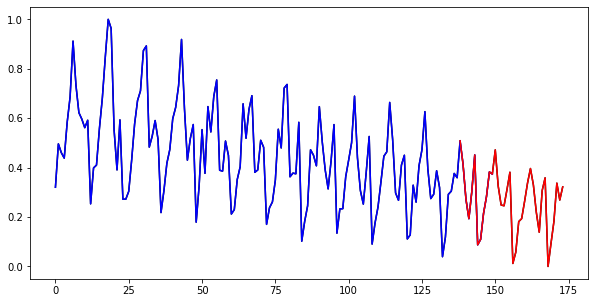

150 36


In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))
F_tr, F_test = split_signal(Fort, delay, train_size, scaler, True)
train_xx, train_yy = get_ts(F_tr, delay, train_size)
test_xx, test_yy = get_ts(F_test, delay, train_size)

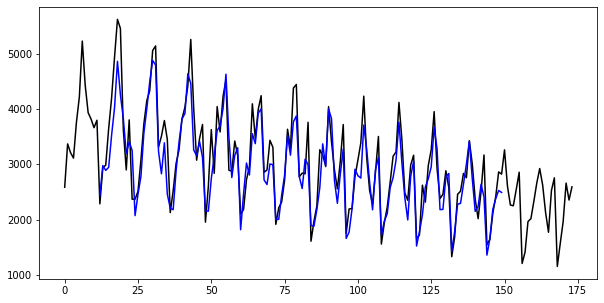

In [38]:
pred_train=[]
for i in range(len(train_xx)):
    out=net(train_xx[i].unsqueeze(-1).to(device))
    pred_train.append(out.detach().cpu().item())
pred_train=np.array(pred_train)
trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[delay:train_size],trainPredict, 'b')
plt.show()

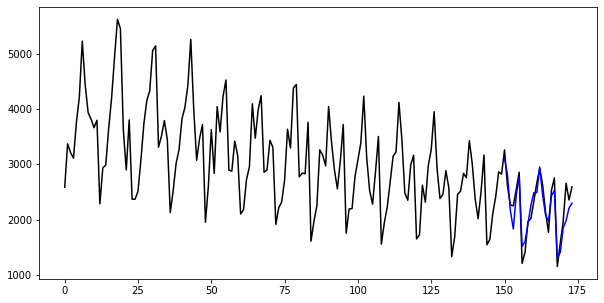

In [39]:
pred_test=[]
for i in range(len(test_xx)):
    out=net(test_xx[i].unsqueeze(-1).to(device))
    pred_test.append(out.detach().cpu().item())
pred_test=np.array(pred_test)
testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[train_size:len(Fort)],testPredict, 'b')
plt.show()

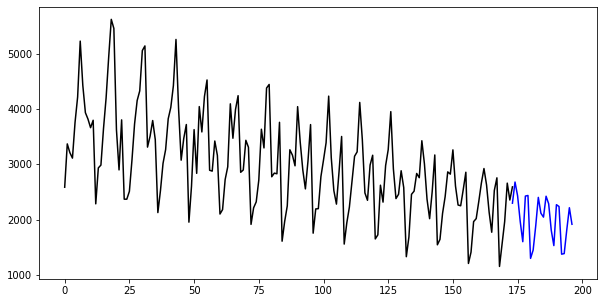

In [40]:
pred_forecast=[]
inp=test_xx[-1].unsqueeze(-1).to(device)
for i in range(24):
    out=net(inp)
    out=out.detach().cpu().item()
    pred_forecast.append(out)
    inp[0,0,0]=out
    inp=inp.roll(-1)
pred_forecast=np.array(pred_forecast)
forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[len(Fort)-1:len(Fort)+24-1],forecastPredict, 'b')
plt.show()

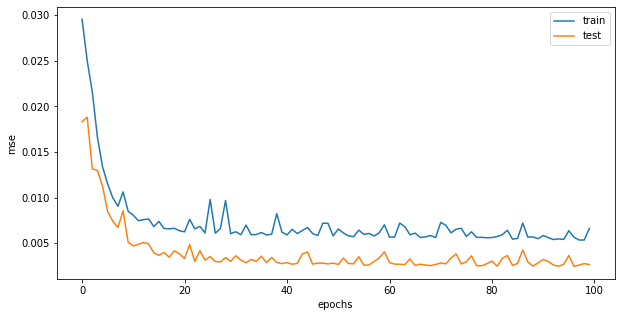

In [41]:
plt.figure(figsize = (10, 5))
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

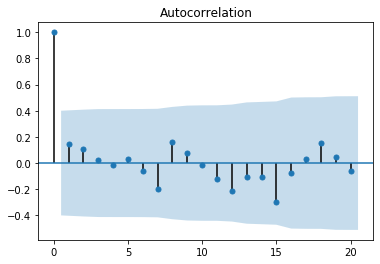

In [42]:
plot_acf(test_yy.ravel()-pred_test, lags = 20)
plt.show()

## complex_fort_model

In [43]:
delay=complex_fort_model_result.head(1)['delay'].values[0]
neuron=complex_fort_model_result.head(1)['neuron'].values[0]
train_size=complex_fort_model_result.head(1)['btch_sz'].values[0]
drpout=complex_fort_model_result.head(1)['drpout'].values[0]

In [44]:
checkpoint=torch.load(MODELS_DIR+'/complex_fort_model_{}_{}_{}_{}.t7'.format(delay, neuron, train_size, drpout))

net=Net(1, delay, neuron, drpout).to(device)
net.load_state_dict(checkpoint['state'])
net.eval()

train_mse = checkpoint['train_mse']
test_mse = checkpoint['test_mse']

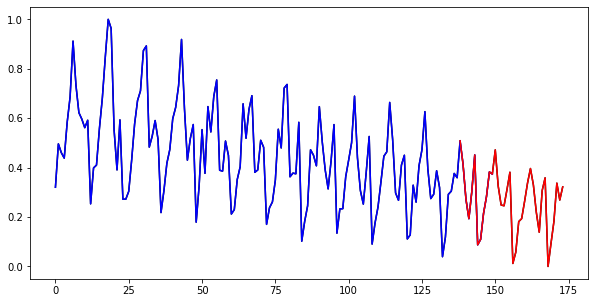

150 36


In [45]:
scaler = MinMaxScaler(feature_range=(0, 1))
F_tr, F_test = split_signal(Fort, delay, train_size, scaler, True)
train_xx, train_yy = get_ts(F_tr, delay, train_size)
test_xx, test_yy = get_ts(F_test, delay, train_size)

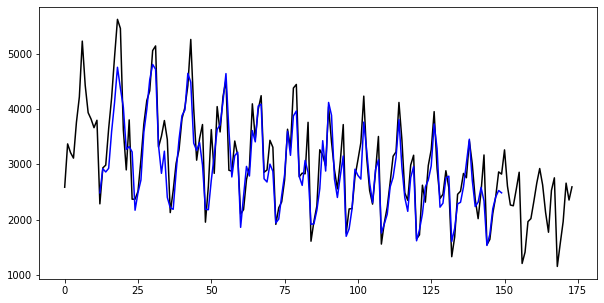

In [46]:
pred_train=[]
for i in range(len(train_xx)):
    out=net(train_xx[i].unsqueeze(-1).to(device))
    pred_train.append(out.detach().cpu().item())
pred_train=np.array(pred_train)
trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[delay:train_size],trainPredict, 'b')
plt.show()

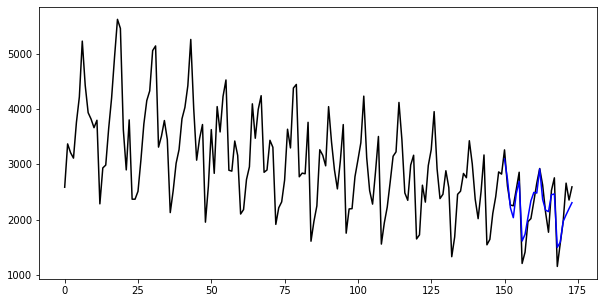

In [47]:
pred_test=[]
for i in range(len(test_xx)):
    out=net(test_xx[i].unsqueeze(-1).to(device))
    pred_test.append(out.detach().cpu().item())
pred_test=np.array(pred_test)
testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[train_size:len(Fort)],testPredict, 'b')
plt.show()

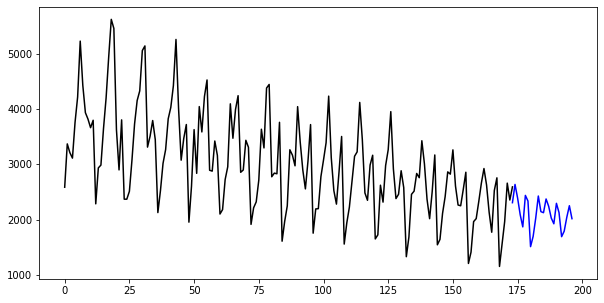

In [48]:
pred_forecast=[]
inp=test_xx[-1].unsqueeze(-1).to(device)
for i in range(24):
    out=net(inp)
    out=out.detach().cpu().item()
    pred_forecast.append(out)
    inp[0,0,0]=out
    inp=inp.roll(-1)
pred_forecast=np.array(pred_forecast)
forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[len(Fort)-1:len(Fort)+24-1],forecastPredict, 'b')
plt.show()

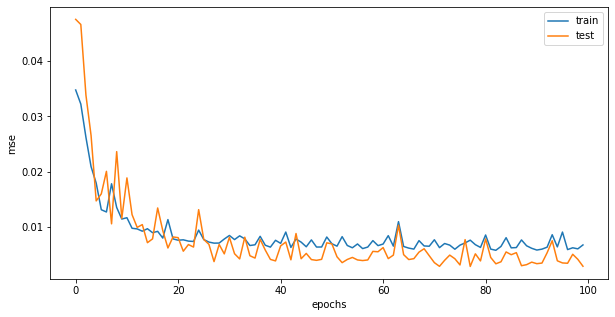

In [49]:
plt.figure(figsize = (10, 5))
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

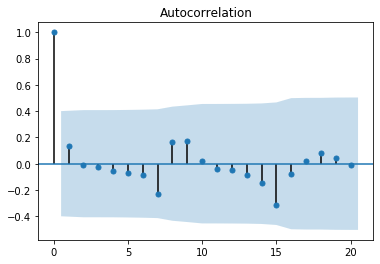

In [50]:
plot_acf(test_yy.ravel()-pred_test, lags = 20)
plt.show()

## 9. Декомпозиция ВР вида 3 кратные сезонные компоненты + шум.

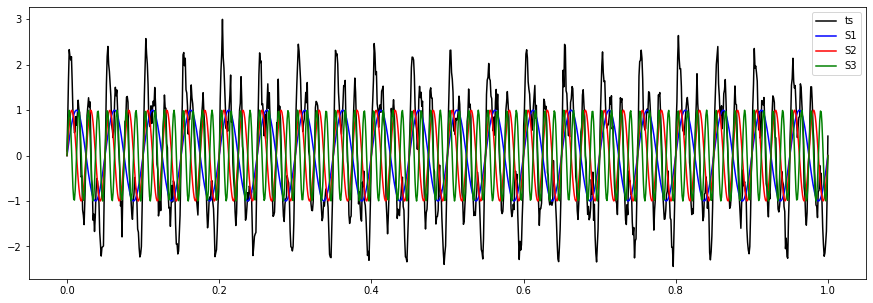

In [51]:
t = np.linspace(0, 1, 1024)

#линейная частота сезона
f = 10 #P = 1/10

S1 = np.sin(2*np.pi*2*f*t)
S2 = np.sin(2*np.pi*4*f*t)
S3 = np.sin(2*np.pi*8*f*t)

noise = 0.2*np.random.randn(len(t))

F_lab = S1 + S2 + S3 + noise
F_lab=F_lab.reshape(-1,1)

N = 1024

plt.figure(figsize = (15, 5))
plt.plot(t, F_lab, 'k', label = 'ts')
plt.plot(t, S1, 'b', label = 'S1')
plt.plot(t, S2, 'r', label = 'S2')
plt.plot(t, S3, 'g', label = 'S3')
plt.legend()
plt.show()

In [55]:
delays=[2, 6, 10, 52]
neurons=[20, 40]
batch_sizes=[800,900]
dropouts=[0.2,0.5]

In [56]:
epochs=100
file_mask=MODELS_DIR+'/simple_lab_model'
simple_lab_model_result=pd.DataFrame()

In [57]:
for delay in delays:
    for neuron in neurons:
        for btch_sz in batch_sizes:
            train_mse, test_mse, end=train(F_lab, epochs, file_mask, delay=delay, neuron=neuron, btch_sz=btch_sz)
            simple_lab_model_result=simple_lab_model_result.append([[delay, neuron, btch_sz, train_mse, test_mse, end]], ignore_index=True)
simple_lab_model_result.columns=['delay', 'neuron','btch_sz', 'train_mse', 'test_mse', 'time']
simple_lab_model_result=simple_lab_model_result.sort_values(['test_mse'])
simple_lab_model_result.to_excel('{}_result.xlsx'.format(file_mask), index=None)

0:00:30.754916 delay=2 neuron=20 btch_sz=800 train_mse=0.014 test_mse=0.013
0:00:30.300619 delay=2 neuron=20 btch_sz=900 train_mse=0.014 test_mse=0.013
0:00:31.287677 delay=2 neuron=40 btch_sz=800 train_mse=0.013 test_mse=0.013
0:00:31.207481 delay=2 neuron=40 btch_sz=900 train_mse=0.014 test_mse=0.014
0:00:30.101965 delay=6 neuron=20 btch_sz=800 train_mse=0.016 test_mse=0.015
0:00:29.954945 delay=6 neuron=20 btch_sz=900 train_mse=0.014 test_mse=0.013
0:00:31.016666 delay=6 neuron=40 btch_sz=800 train_mse=0.013 test_mse=0.013
0:00:30.630856 delay=6 neuron=40 btch_sz=900 train_mse=0.016 test_mse=0.014
0:00:29.571207 delay=10 neuron=20 btch_sz=800 train_mse=0.020 test_mse=0.018
0:00:29.395601 delay=10 neuron=20 btch_sz=900 train_mse=0.023 test_mse=0.020
0:00:30.423386 delay=10 neuron=40 btch_sz=800 train_mse=0.019 test_mse=0.017
0:00:30.347793 delay=10 neuron=40 btch_sz=900 train_mse=0.021 test_mse=0.019
0:00:27.289431 delay=52 neuron=20 btch_sz=800 train_mse=0.068 test_mse=0.061
0:00:26

### delay
neuron=20 btch_sz=800

In [58]:
#delays = range(2, 56)
#delays_mse = [0.014, 0.014, 0.015, 0.014, 0.015, 0.015, 0.018, 0.037, 0.020, 0.023, 0.069, 0.078, 0.073, 0.074, 0.085, 0.085, 0.093, 0.100, 0.111, 0.115, 0.107, 0.107, 0.080, 0.083, 0.086, 0.094, 0.074,0.079, 0.074, 0.075, 0.078, 0.080, 0.069, 0.073, 0.095, 0.102, 0.089, 0.091, 0.086, 0.094, 0.104, 0.084, 0.097, 0.110, 0.102, 0.112, 0.103, 0.087, 0.081, 0.079, 0.057, 0.065, 0.070, 0.065]
#plt.axvline(10)
#plt.axvline(15)
#plt.axvline(24)
#plt.axvline(30)
#plt.axvline(34)
#plt.axvline(40)
#plt.axvline(43)
#plt.axvline(50)
#plt.axvline(52)
#plt.plot(delays, delays_mse)

In [59]:
epochs=100
file_mask=MODELS_DIR+'/complex_lab_model'
complex_lab_model_result=pd.DataFrame()

In [60]:
for delay in delays:
    for neuron in neurons:
        for btch_sz in batch_sizes:
            for drpout in dropouts:
                train_mse, test_mse, end=train(F_lab, epochs, file_mask, delay=delay, neuron=neuron, btch_sz=btch_sz, drpout=drpout)
                complex_lab_model_result=complex_lab_model_result.append([[delay, neuron, btch_sz, drpout, train_mse, test_mse, end]], ignore_index=True)
complex_lab_model_result.columns=['delay', 'neuron','btch_sz', 'drpout', 'train_mse', 'test_mse', 'time']
complex_lab_model_result=complex_lab_model_result.sort_values(['test_mse'])
complex_lab_model_result.to_excel('{}_result.xlsx'.format(file_mask), index=None)

0:01:17.865053 delay=2 neuron=20 btch_sz=800 drpout=0.2 train_mse=0.016 test_mse=0.015
0:01:15.625560 delay=2 neuron=20 btch_sz=800 drpout=0.5 train_mse=0.017 test_mse=0.017
0:01:15.505304 delay=2 neuron=20 btch_sz=900 drpout=0.2 train_mse=0.016 test_mse=0.016
0:01:15.250152 delay=2 neuron=20 btch_sz=900 drpout=0.5 train_mse=0.017 test_mse=0.015
0:01:19.537298 delay=2 neuron=40 btch_sz=800 drpout=0.2 train_mse=0.019 test_mse=0.018
0:01:19.315690 delay=2 neuron=40 btch_sz=800 drpout=0.5 train_mse=0.016 test_mse=0.016
0:01:19.004067 delay=2 neuron=40 btch_sz=900 drpout=0.2 train_mse=0.015 test_mse=0.015
0:01:19.322810 delay=2 neuron=40 btch_sz=900 drpout=0.5 train_mse=0.019 test_mse=0.016
0:01:15.046606 delay=6 neuron=20 btch_sz=800 drpout=0.2 train_mse=0.015 test_mse=0.015
0:01:14.972694 delay=6 neuron=20 btch_sz=800 drpout=0.5 train_mse=0.020 test_mse=0.019
0:01:14.820099 delay=6 neuron=20 btch_sz=900 drpout=0.2 train_mse=0.020 test_mse=0.017
0:01:15.212511 delay=6 neuron=20 btch_sz=90

In [61]:
simple_lab_model_result.head()

,delay,neuron,btch_sz,train_mse,test_mse,time
6,6,40,800,0.012914,0.012520,00:00:31.016666
2,2,40,800,0.013319,0.012729,00:00:31.287677
5,6,20,900,0.014340,0.012906,00:00:29.954945
1,2,20,900,0.013616,0.013115,00:00:30.300619
0,2,20,800,0.014292,0.013427,00:00:30.754916


In [62]:
complex_lab_model_result.head()

,delay,neuron,btch_sz,drpout,train_mse,test_mse,time
14,6,40,900,0.2,0.015417,0.014378,00:01:18.992262
13,6,40,800,0.5,0.015083,0.014410,00:01:17.800056
6,2,40,900,0.2,0.015077,0.014566,00:01:19.004067
3,2,20,900,0.5,0.016680,0.014739,00:01:15.250152
8,6,20,800,0.2,0.015168,0.014934,00:01:15.046606


# Results
## simple model

In [63]:
delay=simple_lab_model_result.head(1)['delay'].values[0]
neuron=simple_lab_model_result.head(1)['neuron'].values[0]
train_size=simple_lab_model_result.head(1)['btch_sz'].values[0]

In [65]:
checkpoint=torch.load(MODELS_DIR+'/simple_lab_model_{}_{}_{}.t7'.format(delay,neuron,train_size))

net=Net(1, delay, neuron).to(device)
net.load_state_dict(checkpoint['state'])
net.eval()

train_mse = checkpoint['train_mse']
test_mse = checkpoint['test_mse']

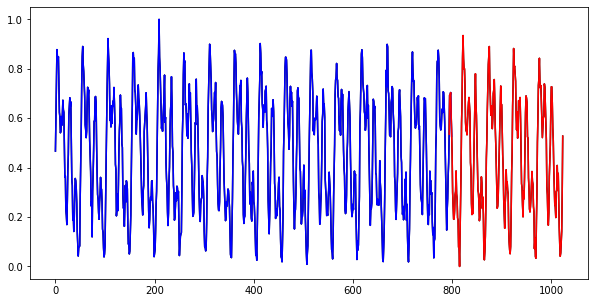

800 230


In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))
F_tr, F_test = split_signal(F_lab, delay, train_size, scaler, True)
train_xx, train_yy = get_ts(F_tr, delay, train_size)
test_xx, test_yy = get_ts(F_test, delay, train_size)

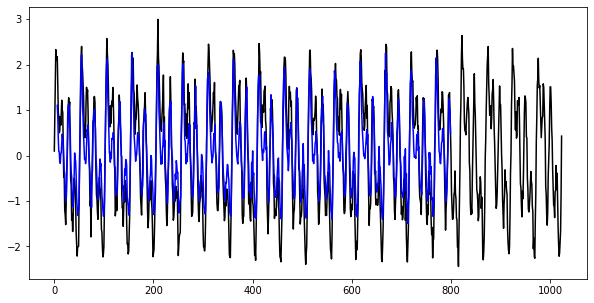

In [67]:
pred_train=[]
for i in range(len(train_xx)):
    out=net(train_xx[i].unsqueeze(-1).to(device))
    pred_train.append(out.detach().cpu().item())
pred_train=np.array(pred_train)
trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[delay:train_size],trainPredict, 'b')
plt.show()

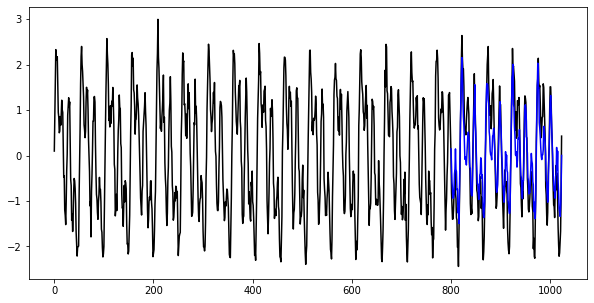

In [68]:
pred_test=[]
for i in range(len(test_xx)):
    out=net(test_xx[i].unsqueeze(-1).to(device))
    pred_test.append(out.detach().cpu().item())
pred_test=np.array(pred_test)
testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[train_size:len(F_lab)],testPredict, 'b')
plt.show()

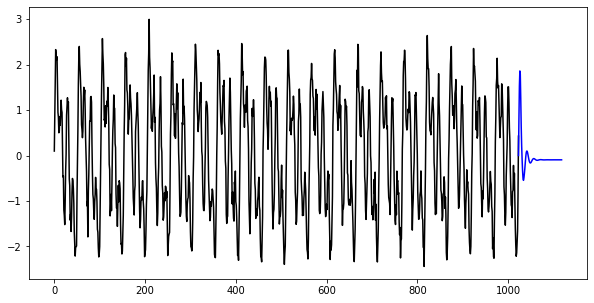

In [69]:
for_forecast=96
pred_forecast=[]
inp=test_xx[-1].unsqueeze(-1).to(device)
for i in range(for_forecast):
    out=net(inp)
    out=out.detach().cpu().item()
    pred_forecast.append(out)
    inp[0,0,0]=out
    inp=inp.roll(-1)
pred_forecast=np.array(pred_forecast)
forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[len(F_lab)-1:len(F_lab)+for_forecast-1],forecastPredict, 'b')
plt.show()

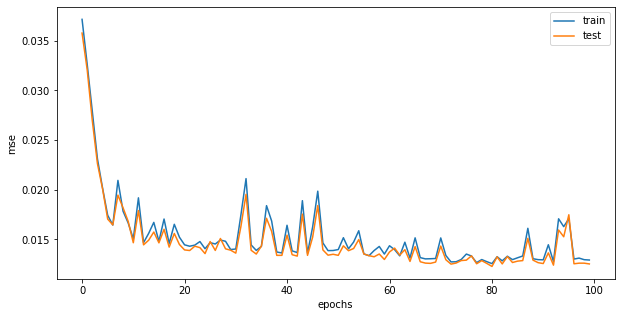

In [70]:
plt.figure(figsize = (10, 5))
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

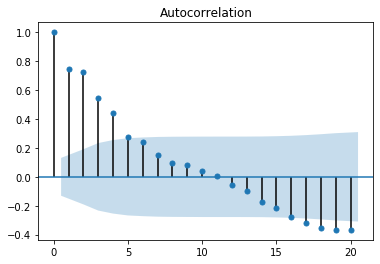

In [71]:
plot_acf(test_yy.ravel()-pred_test, lags = 20)
plt.show()

## complex model

In [72]:
delay=complex_lab_model_result.head(1)['delay'].values[0]
neuron=complex_lab_model_result.head(1)['neuron'].values[0]
train_size=complex_lab_model_result.head(1)['btch_sz'].values[0]
drpout=complex_lab_model_result.head(1)['drpout'].values[0]

In [73]:
checkpoint=torch.load(MODELS_DIR+'/complex_lab_model_{}_{}_{}_{}.t7'.format(delay,neuron,train_size,drpout))

net=Net(1, delay, neuron, drpout).to(device)
net.load_state_dict(checkpoint['state'])
net.eval()

train_mse = checkpoint['train_mse']
test_mse = checkpoint['test_mse']

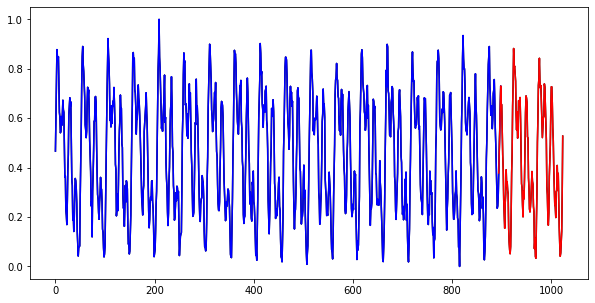

900 130


In [74]:
scaler = MinMaxScaler(feature_range=(0, 1))
F_tr, F_test = split_signal(F_lab, delay, train_size, scaler, True)
train_xx, train_yy = get_ts(F_tr, delay, train_size)
test_xx, test_yy = get_ts(F_test, delay, train_size)

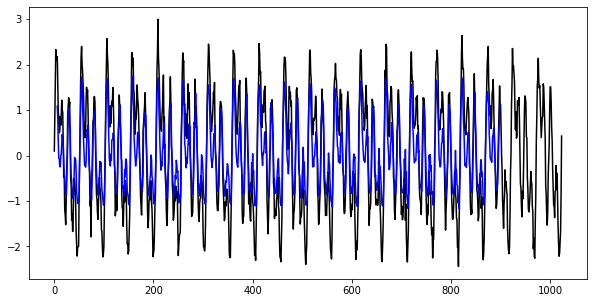

In [75]:
pred_train=[]
for i in range(len(train_xx)):
    out=net(train_xx[i].unsqueeze(-1).to(device))
    pred_train.append(out.detach().cpu().item())
pred_train=np.array(pred_train)
trainPredict = scaler.inverse_transform(pred_train.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[delay:train_size],trainPredict, 'b')
plt.show()

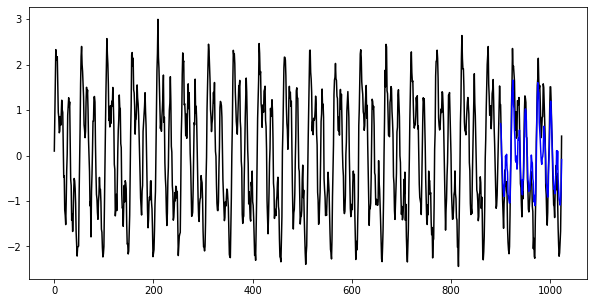

In [76]:
pred_test=[]
for i in range(len(test_xx)):
    out=net(test_xx[i].unsqueeze(-1).to(device))
    pred_test.append(out.detach().cpu().item())
pred_test=np.array(pred_test)
testPredict = scaler.inverse_transform(pred_test.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[train_size:len(F_lab)],testPredict, 'b')
plt.show()

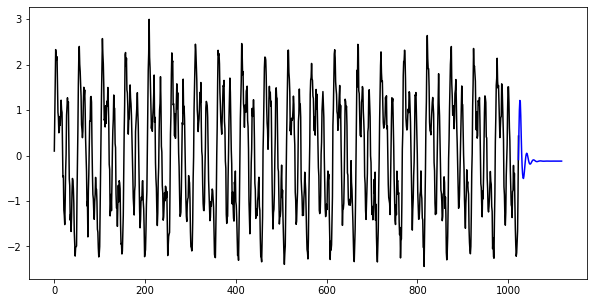

In [77]:
for_forecast=96
pred_forecast=[]
inp=test_xx[-1].unsqueeze(-1).to(device)
for i in range(for_forecast):
    out=net(inp)
    out=out.detach().cpu().item()
    pred_forecast.append(out)
    inp[0,0,0]=out
    inp=inp.roll(-1)
pred_forecast=np.array(pred_forecast)
forecastPredict = scaler.inverse_transform(pred_forecast.reshape(-1,1))
plt.figure(figsize = (10, 5))
plt.plot(F_lab, 'k')
plt.plot(np.r_[len(F_lab)-1:len(F_lab)+for_forecast-1],forecastPredict, 'b')
plt.show()

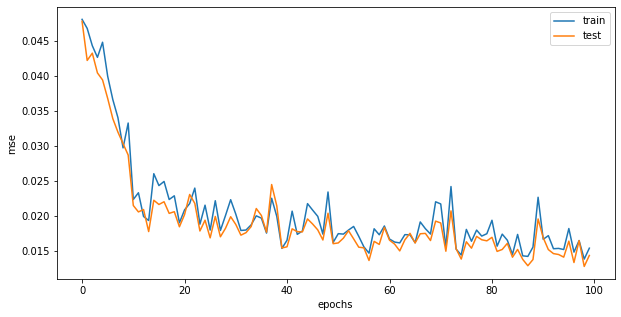

In [78]:
plt.figure(figsize = (10, 5))
plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()
plt.show()

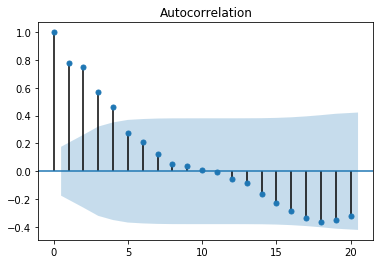

In [79]:
plot_acf(test_yy.ravel()-pred_test, lags = 20)
plt.show()

# Keras 

In [ ]:
model = Sequential() # слои соединены последовательно
model.add(LSTM(units=20, input_shape=(1, 6))) # 20 нейронов
model.add(Dense(units = 1)) # выход одномерный
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png') # рисунок полученной сети

In [ ]:
model.fit(xx, yy, epochs = 100) # 100 эпох по 144 точки

In [ ]:
trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[6:150],trainPredict, 'b')
plt.show()

In [ ]:
testPredict = model.predict(xx_test)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[150:174],testPredict, 'b')
plt.show()

In [ ]:
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(1, 6)))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png')

In [ ]:
model.fit(xx, yy, epochs = 100) # 100 эпох по 144 точки

In [ ]:
trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[6:150],trainPredict, 'b')
plt.show()

In [ ]:
testPredict = model.predict(xx_test)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[150:174],testPredict, 'b')
plt.show()